<a href="https://colab.research.google.com/github/Dexne/Pattern_Recognition/blob/main/11_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Reconocimiento de patrones**

**Máquina de soporte vectorial**

Instalaremos primeramente una biblioteca de programación cuadrática

In [1]:
pip install cvxopt

importamos paquetería necesaria

In [2]:
import cvxopt
import numpy as np
import matplotlib.pyplot as plt

Creamos nuestra clase SVM

In [3]:
class SVM():

    def __init__(self, kernel='linear', C=0.001, gamma=0.001, degree=3):

        # Parametros de funciones kernel
        self.C = float(C)
        self.gamma = float(gamma)
        self.d = int(degree)

        if kernel == 'linear':
            self.kernel = self.linear
        elif kernel == 'polynomial':
            self.kernel = self.polynomial
        elif kernel == 'gaussian':
            self.kernel = self.gaussian
        else:
            raise NameError('Kernel no reconocido')

    # Funciones Kernel
    def linear(self, x1, x2):
        return np.dot(x1, x2)

    def polynomial(self, x1, x2):
        return (np.dot(x1, x2) + 1) ** self.d

    def gaussian(self, x1, x2):
        return np.exp(-self.gamma * np.linalg.norm(x1 - x2) ** 2)

    # Algoritmo de entrenamiento
    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Matriz de Gram
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])


        # Resolver problema con cvxopt --------------------------------
        P = cvxopt.matrix(np.outer(y, y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1, n_samples))
        b = cvxopt.matrix(0.0)

        if self.C == 0:
            G = cvxopt.matrix(np.identity(n_samples) * -1)
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.identity(n_samples) * -1
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        cvxopt.solvers.options['show_progress'] = False
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
        # -----------------------------------------------------------

        # Extraer multiplicadores de lagrange
        lamb = np.ravel(solution['x'])

        # Detectar vectores soporte
        mask = lamb > 1e-5
        ind = np.arange(len(lamb))[mask]
        self.lamb = lamb[mask]

        # Extraer vectores soporte
        self.sv = X[mask]
        self.sv_y = y[mask]

        # Calcular sesgo b
        self.b = 0
        for i in range(len(self.lamb)):
            self.b += self.sv_y[i]
            self.b -= np.sum(self.lamb * self.sv_y * K[ind[i], mask])
        self.b = self.b / len(self.lamb)


    def project(self, X):
        y_predict = np.zeros(len(X))
        for i in range(len(X)):
            s = 0
            for a, sv_y, sv in zip(self.lamb, self.sv_y, self.sv):
                s += a * sv_y * self.kernel(X[i], sv)
            y_predict[i] = s
        return y_predict + self.b

    def predict(self, X):
        return np.sign(self.project(X))

Función para ayudarnos a dibujar

In [5]:
def plot_svm(x, y, model):

    plt.figure(figsize=(10,10))

    # Dibujar datos de cada clase:
    plt.plot(x[y == 1, 0], x[y == 1, 1],'bo', markersize=9)
    plt.plot(x[y == -1, 0], x[y == -1, 1], 'ro',markersize=9)

    # Calcular limites
    xmin, xmax = x[:,0].min()-0.5, x[:,0].max()+0.5
    ymin, ymax = x[:,1].min()-0.5, x[:,1].max()+0.5

    # Dibujar superficie de decisión y margenes
    xx, yy = np.meshgrid(np.linspace(xmin, xmax, 100),
                         np.linspace(ymin, ymax, 100))
    data = np.array([xx.ravel(), yy.ravel()]).T
    zz = model.project(data).reshape(xx.shape)
    plt.contour(xx, yy, zz, [0.0], colors='k', linewidths=2)
    plt.contour(xx, yy, zz, [-1.0, 1.0], colors='grey',
                linestyles='--', linewidths=2)
    plt.contourf(xx, yy, zz, [min(zz.ravel()), 0.0, max(zz.ravel())],alpha=0.8,
                 cmap=plt.cm.RdBu )

    # Dibujar vectores soporte
    plt.scatter(model.sv[:, 0], model.sv[:, 1], s=200, color="gold")

    # Detallar figura
    plt.xlabel(r'x1', fontsize=20)
    plt.ylabel(r'x2', fontsize=20)
    plt.title('Support Vector Machine', fontsize=20)
    #plt.title(r'Gamma={0:3.3f}, C={1:3.3f}'.format(model.gamma, model.C), fontsize=15);
    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    plt.grid()
    plt.show()

Solo corre uno de los siguientes bloques

In [6]:
# Problema 1
np.random.seed(24)
mean1 = np.array([0, 2])
mean2 = np.array([2, 0])
cov = np.array([[1.5, 1], [1, 1.5]])
X1 = np.random.multivariate_normal(mean1, cov, 100)
X2 = np.random.multivariate_normal(mean2, cov, 100)
x = np.vstack((X1, X2))
y = np.hstack((np.ones(len(X1)), np.ones(len(X1))*-1))

In [7]:
from sklearn.datasets import make_moons
x, y = make_moons(200, noise=0.2)
y = np.asanyarray(y, dtype=np.float64)
y += (y==0) * - 1.0

crea, entrena y vizualiza la SVM

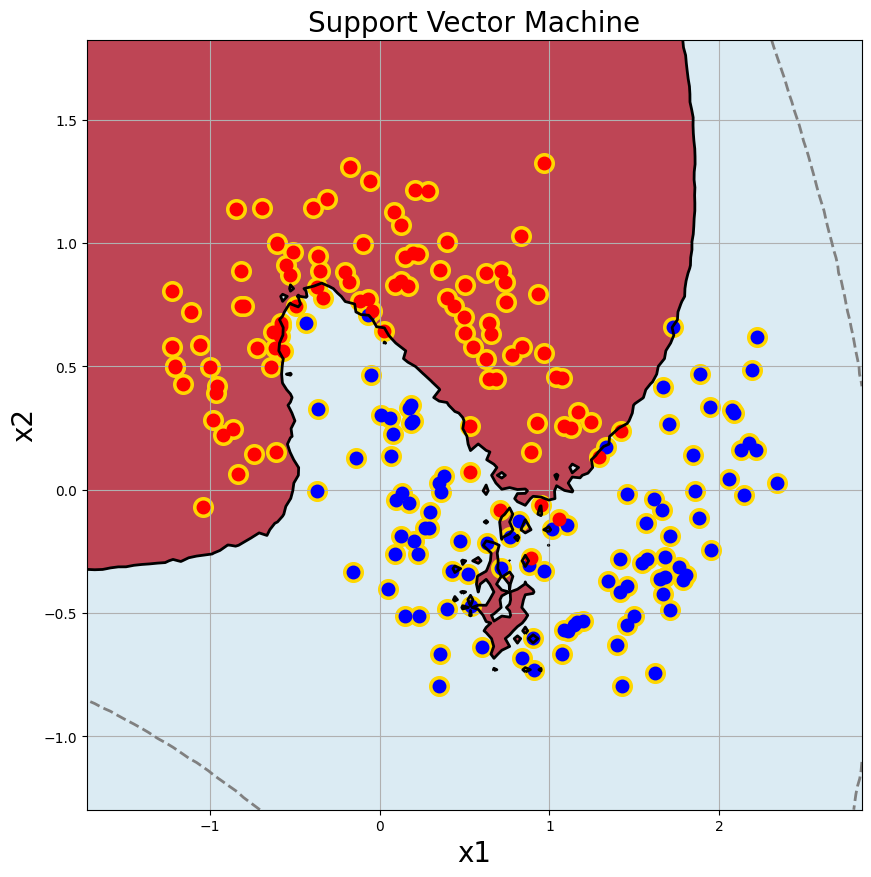

In [8]:
model = SVM(kernel='gaussian', C=0, gamma=0.001)
model.fit(x, y)
plot_svm(x, y, model)